# Performance comparison between REV and Google

We will compare the WER distribution between [rev.ai](http://rev.ai) and google's transscription API.  
We are using the testing examples of the [Noisy Speech Database](https://datashare.is.ed.ac.uk/handle/10283/2791), downsampled to 8Khz to approximate the most common phone sample rate, which affects the model's performance.  

**Caveat**: This dataset is free and of open access, thus, is possible that it was used for the api's training and thus, overfitted. For ths comparison to be more robust, original audios must be used. 


## Requirements

Libraries required for the test.

In [143]:
# Libraries

#!pip install -q jiwer
#!pip install -q spacy
#!pip install -q pydub
#!pip install -q tqdm
#!pip install -q --upgrade google-cloud-speech
#!pip install -q --upgrade rev_ai
#!pip install -q seaborn

#!python -m spacy download en_core_web_md

# If you want to train and compare with deepspeech fine tunined for 8khz, you will need this:
#!pip install deepspeech
#!pip install deepspeech-gpu


You should consider upgrading via the '/home/fernando/anaconda3/envs/asr/bin/python3.8 -m pip install --upgrade pip' command.


## Load libraries

In [1]:
# General
import os
import numpy as np
from numpy import ndarray
import IPython.display as ipd
from tqdm import tqdm
import seaborn
from typing import List

# For performance measure
import jiwer
import spacy
nlp = spacy.load("en_core_web_md", disable=["ner", "parser"])

# To feed audio
import wave
from scipy.io.wavfile import write
from pydub import AudioSegment as am
import io

## Utility functions

**Word error rate**: We will use the word error rate as a measure of performance. It will serve as a distance between the correct transcription and the model's. We will remove interjections, which are words used to express strong feeling or sudden emotion.

In [2]:
def find_interjections(texts: List[str], interj_to_keep: List[str] = []) -> list:
    """Remove interjections.

    Interjections are words used to express sudden emotion such as surprise, disgust, etc.
    An interjection is not grammatically related to any other part of the sentence.
    We wont consider it in the wer.
    
    :params texts:    Texts whose interjections will be removed
    :params interj_to_keep:    List of interjections to keep. 
    """
    list_intj = []
    # we use spacys POS tagger to find interjections
    for doc in nlp.pipe(texts):
        list_intj.extend([token.text for token in doc if\
                          token.pos_ == 'INTJ' and\
                          token.lower_ not in interj_to_keep])
    return list(set(list_intj))

def calc_wer(ground_truth: List[str], hypothesis: List[str]) -> float:
    """ Compute word error rate.

    Widely used measure of error fron transcriptions.
    At low values its performance is similar yo KER, see: http://www.patwardhans.net/papers/ParkPVG08.pdf.
    In this implementation we remove interjections, punctuation, strip trailing spaces and multiple spaces, and
        expand common english contractions.
    :params ground_truth:    List of correct transcriptions. Same sort order as hypothesis.
    :params hypothesis:    List of model's transcription. Same sort order as ground_truth.
    """
    # Remove interjections
    corpus = ground_truth + hypothesis
    # Simple preliminary list
    interj_to_keep = ['yes', 'yeah', 'no', 'na', 'hello']
    interjections = find_interjections(corpus, interj_to_keep)
    
    # Preprocessing pipe to compue wer
    transformation = jiwer.Compose([
        jiwer.RemoveSpecificWords(interjections),
        jiwer.RemovePunctuation(),
        jiwer.Strip(),
        jiwer.RemoveEmptyStrings(),
        jiwer.RemoveMultipleSpaces(),
        jiwer.ToLowerCase(),
        jiwer.SentencesToListOfWords(word_delimiter=" "),
        jiwer.ExpandCommonEnglishContractions(),
    ]) 
    
    # calc wer
    wer = jiwer.wer(
        ground_truth, 
        hypothesis, 
        truth_transform=transformation, 
        hypothesis_transform=transformation
    )
    return wer

ground_truth = ["hello eh world No", "i like monthy python Yes"]
hypothesis = ["hello duck na", "i like uhm python let's yeah"]
calc_wer(ground_truth, hypothesis)

0.625

## Datasets

**Audios**: We are using the testing examples of the [Noisy Speech Database](https://datashare.is.ed.ac.uk/handle/10283/2791). Download the [test audios](https://datashare.is.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip?sequence=5&isAllowed=y) and [test transcriptions](https://datashare.is.ed.ac.uk/bitstream/handle/10283/2791/testset_txt.zip?sequence=8&isAllowed=y). The database was designed to train and test speech enhancement methods, and has 28 speakers.  

**Preprocessing**: The data is in 16Khz, but telephone conversations are typically in 8Khz. Thus, we must downsample the audios, which will reduce quality and make the task more difficult.


In [3]:
# build paths for later accesing the audios and transcriptions
audios_folder = 'audio/Noisy speech database - Valentini/noisy_testset_wav/'
audios_path = [audios_folder+filename for filename in os.listdir(audios_folder)]
transcriptions_folder = 'audio/Noisy speech database - Valentini/testset_txt/testset_txt/'

# Folder for downsampled audios
downsampled_folder = 'audio/Noisy speech database - Valentini/downsampled_audios/'
try:
    os.mkdir(downsampled_folder)
except FileExistsError:
    pass

# For each filename in the audios folder, create a path in the downsampled folder
downsampled_audios_path = [downsampled_folder+filename for filename in os.listdir(audios_folder)]

# Downsample audios to 8kHz, most common telephone rate.
# for i in tqdm(range(len(audios_path))):
#     signal = am.from_file(audios_path[i], format='wav', frame_rate=768000)
#     signal = signal.set_frame_rate(8000)
#     signal.export(downsampled_audios_path[i], format='wav')

**Generator**: We will make a generator that will feed the audio and its transcription, without loading the whole databse to memory.

In [31]:
def data_generator(audios_folder: List[str], transcriptions_folder: List[str]) -> tuple:
    """Generator that feeds audio, transcription and filename tuple.
    """
    # For each audio filename in the audio folder
    filenames = os.listdir(audios_folder)
    for f in filenames:
        # Open the audio filename and read audio bytes
        with io.open(audios_folder+f, 'rb') as audio_file:
            audio_data = audio_file.read()
        # Open the transcription with the same filename and read to string
        with open(transcriptions_folder + f.replace('.wav','.txt')) as file:
            transcription = file.read().strip('\n')
        yield (audio_data, transcription, f)

In [32]:
# Build generator
downsampled_generator = data_generator(downsampled_folder, transcriptions_folder)
# test
audio_data, transcription, file = next(downsampled_generator)
print(f"ground truth: {transcription}")
# Listen
ipd.Audio(audio_data, rate=8000) # load a local WAV file

ground truth: The goals were good.


## Testing

**Google**: Google's API needs to use some *json* credentials. We will save them in the `credentials/google_credentials.json` path. We also set two parameters: `sample_rate_hertz=8000` and `model='phone_call'`, because we are dealing with phonecall quality audio.  
We will save all the results in a `tsv` file with the structure `transcript|ground_truth|filename`.

In [19]:
# Load credentials

if not os.path.isfile("credentials/google_credentials.json"):
    raise Exception("No credentials found, wont be able to use google's API")
else:
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="credentials/google_credentials.json"

In [118]:
# Imports the Google Cloud client library
from google.cloud import speech
from google.cloud.speech import enums
from google.cloud.speech import types

# file to save results
if not os.path.exists('results/google.csv'):
    with open('results/google.csv', 'w') as f:
        f.write('google_api|ground_truth|filename\n')

# Instantiates a client
client = speech.SpeechClient()

# Generator
downsampled_generator = data_generator(downsampled_folder, transcriptions_folder)

for i in range(50):
    # Fetch data
    audio_data, ground_truth, file = next(downsampled_generator)

    # Config post, use 'phone_call', given that we are working with 8khz
    audio = types.RecognitionAudio(content=audio_data)
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=8000,
        language_code='en-US',
        model='phone_call')

    # Transcribe
    response = client.recognize(config, audio)
    
    # Write to file
    for result in response.results:
        print(f'Transcript: {result.alternatives[0].transcript}, Ground truth: {ground_truth}')
    with open('results/google.csv', 'a') as f:
        f.write(f'{result.alternatives[0].transcript}|{ground_truth}|{file}\n')

Transcript: The goals we're good., Ground truth: The goals were good.
Transcript: They said said I would look good in uniform., Ground truth: They said so that I would look good in uniform.
Transcript: 64 Salem Seekers left the offices of reported, Ground truth: Six of the asylum seekers left the offices, it was reported.
Transcript: They might have the last laugh., Ground truth: They may yet have the last laugh.
Transcript: question later, Ground truth: It's quite a line-up!
Transcript: Miss McNeil with killed Olympics, Ground truth: Ms McNeill was killed on impact.
Transcript: The record companies have come through the floor., Ground truth: The record companies have gone through the floor.
Transcript: This is me., Ground truth: Does this mean.
Transcript: The departure of Mr. Johnston it was reported by the Harold yesterday., Ground truth: The departure of Mr Johnston was reported by The Herald yesterday.
Transcript: It is a whole package., Ground truth: It is the whole package.
Tran

**rev.ai**: [API documentation](https://pypi.org/project/rev-ai). Rev's API needs to use a token. We will save it in the `credentials/rev_token.txt` path. The API wont let use set any parameter regarding the audio quality or choosing a model, thus, it must infer it.  
We will save the results in a `tsv` file with the structure `transcription|ground_truth|filename`

In [ ]:
from rev_ai import apiclient

# Load credentials
if not os.path.isfile("credentials/rev_token.txt"):
    raise Exception("No credentials found, wont be able to use rev's API")
else:
    with open('credentials/rev_token.txt', 'r') as token:
        token_ = token.read().replace('\n', '')
        client = apiclient.RevAiAPIClient(token_)


### Attention!

There seems to be a bug in the API, where the 8Khz file is passed as an 16Khz WAV, thus it's inferred duration is too low and the model fails.  
Thus, to make a quick comparison experiment, I uploaded through Rev's webpage dashboard 20 audios.

In [205]:
###############################
# Wont run, see comment above #
###############################

# rev_downsampled_generator = data_generator(downsampled_folder, transcriptions_folder)
# audio_data, ground_truth, file = next(rev_downsampled_generator)
# tmp_path = downsampled_folder+file
# print(tmp_path)
# job = client.submit_job_local_file(tmp_path, speaker_channels_count=1)

# transcript_text = client.get_transcript_text(job.id)
# print(f'Transcript: {transcript_text}, Ground truth: {ground_truth}')

audio/Noisy speech database - Valentini/downsampled_audios/p232_137.wav


HTTPError: 409 Client Error: Conflict for url: https://api.rev.ai/speechtotext/v1/jobs/yxojyNM5C1ba/transcript; Server Response : {"allowed_values":["transcribed"],"current_value":"failed","type":"https://www.rev.ai/api/v1/errors/invalid-job-state","title":"Job is in invalid state","status":409,"detail":"Job is in invalid state to obtain the output","extensions":{}}

In [87]:
# Move audios tested on google to a new folder for manual uploading to rev.ai

from shutil import copyfile
with open('results/google.csv', 'r') as f:
    file = f.read().split('\n')
filenames = [downsampled_folder+f.split(',')[-1] for f in file][1:-1]
for f in filenames:
    copyfile(f, 'results/audios_tested/'+f.split('/')[-1])

In [117]:
# Get the last 20 audios sent to transcribe manually

jobs = client.get_list_of_jobs(limit=20)

# file to save results
if not os.path.exists('results/rev.csv'):
    with open('results/rev.csv', 'w') as f:
        f.write('rev_api|ground_truth|filename\n')

# FOr each transcription job, get transcript and append to file
for j in jobs:
    try:
        transcript = client.get_transcript_text(j.id)
        transcript = transcript.split('  ')[-1].replace('\n','')
        tmp_path = transcriptions_folder + j.name.replace('wav', 'txt')
        with open(tmp_path, 'r') as f:
            ground_truth = f.read()
        print(f'Transcript: {transcript}, Ground truth: {ground_truth}')
        with open('results/rev.csv', 'a') as f:
            f.write(f"{transcript}|{ground_truth}|{j.name}\n")
    except:
        next

Transcript: I'd never seen a play about me. , Ground truth: I'd never seen a play about me.

Transcript: When a man looks for something beyond his reach friends. So he's looking for the pot of gold at the end of the rainbow. , Ground truth: When a man looks for something beyond his reach, his friends say he is looking for the pot of gold at the end of the rainbow. 

Transcript: We are now looking at the degrees of injury. , Ground truth: We are now looking at the degrees of injury.

Transcript: That was the lesson to be learned from the European championships. , Ground truth: That was the lesson to be learned from the European Championships.

Transcript: This interview is expected to be in hospital for several days. , Ground truth: The singer is expected to be in hospital for several days.

Transcript: She died in hospital two hours later. , Ground truth: She died in hospital two hours later.

Transcript: Results is sometimes contentious. , Ground truth: The results are sometimes conte

## Results

**Process**: We have two files, one for each API, with thir transcriptions and the filename of the audio. We will:
1. Inner join the two results `tsv` by audio filename, so as to compare only the audios both transcribed.
2. Get the WER of each API.
3. Graph WER distributions.

In [215]:
import pandas as pd

# Inner join rev's and google's trancriptions into a dataframe, using the filename as key
rev = pd.read_csv('results/rev.csv', sep='|')
google = pd.read_csv('results/google.csv', sep='|')
data = pd.merge(rev, google, on=['filename', 'ground_truth'], suffixes=['_rev','_google'])

**Overall WER**

In [222]:
# Compute WER for each API
rev_wer = calc_wer(data['ground_truth'].tolist(), data['rev_api'].tolist())
google_wer = calc_wer(data['ground_truth'].tolist(), data['google_api'].tolist())
print(f"Rev's wer:{rev_wer:.4f}, google's wer: {google_wer:.4f}.\nRev's wer is {rev_wer/google_wer:.4f} times that of google's.")
print(f"Disclaimer: tested on {data.shape[0]} open access audios.")

Rev's wer:0.0829, google's wer: 0.2878.
Rev's wer is 0.2881 times that of google's.
Disclaimer: tested on 20 open access audios.


**WER distribution**

In [223]:
# Individual transcriptions WER
data['rev_wer'] = data.apply(lambda x: calc_wer(x['ground_truth'], x['rev_api']), axis=1)
data['google_wer'] = data.apply(lambda x: calc_wer(x['ground_truth'], x['google_api']), axis=1)
# reformat dataframe for plotting
wers = pd.DataFrame()
wers['wer'] = np.append(data['rev_wer'], data['google_wer'])
wers['api'] = ['rev' for _ in range(data.shape[0])] + ['google' for _ in range(data.shape[0])]

Text(0.5, 0.98, 'Google vs Rev STT')

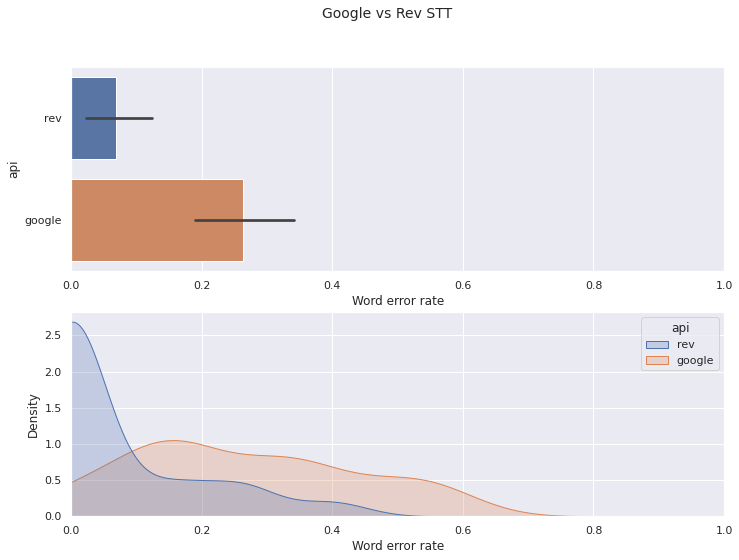

In [231]:
import seaborn as sns
from matplotlib import pyplot as plt

f, axs = plt.subplots(2, 1)
#sns.set(rc={'figure.figsize':(20,10)})
f.set_size_inches(11.7, 8.27)
_ = sns.barplot(data=wers, x="wer", y="api", ax=axs[0]).set(xlim=(0, 1.0))
_ = sns.kdeplot(data=wers, x="wer", hue="api", fill=True, ax=axs[1], bw_adjust=0.8).set(xlim=(0, 1.0))
_ = axs[0].xaxis.set_label_text('Word error rate')
_ = axs[1].xaxis.set_label_text('Word error rate')
f.suptitle(f'Google vs Rev STT', fontsize=14)